# Logistic Regression: Python Implementation, Cross Validation: First Encounter

## Objectives

In this session, we want to see Logistic Regression in action. On top of it, we want to have our first pass on cross validation, a model validation technique which is used extensively. In many works related with machine learning, specially on the more academic side, we are not only interested in how our model under test performs, but also how it performance compares to that of some other alternatives. All the other alternatives are called _baseline_ in machine learning literature. 

Baseline comparison enables us to gain a better understanding of the toughness of the task at hand and also helps us evaluate the trade-offs better. For example, let's say we are measuring performance by AUROC. Let's assume the model we are developing has an AUROC of 0.95 and a one of our baselines has an AUROC of 0.93. This shows we have made an improvement over what has been already there. However, let's say our model takes 2 days to train whereas our baseline takes 10 minutes. Depending on the application, it might be worth it to compromise the AUROC by 0.02 and stick to the model that takes less.

In our case of Logistic Regression, we are using Ridge Regression, and LASSO Regression as the baselines. We do not expand upon what they are here and we encourage the reader to figure them out on their own if interested. The comparison will be made based on AUROC and the absolute value of coefficients of each model (a measure of _overfitness_). 

We also learn a simple method for handling missing values which is removing such records. We also see how one hot encoding is performed. Nearly all models in Python want the labels of the dataset to be numerical so we see a method to do so. We then perform a stratified K-fold cross-validation to compare the AUROC among the three aforementioned models. For two of them we do an internal grid search in advance. After obtaining best hyperparameters, we train three final models to compare the coefficients obtained by each model. Therefore, this week we learn:
* Dropping: a simple way of handling missingness in data
* One-hot encoding
* Changing the label to the right format
* Stratified K-fold for obtaining average AUROC for Logistic Regression, Ridge Regression, and LASSO Regression
* Internal grid search for hyperparameter tuning
* Coefficient comparison among different models

## Preparing the Data

Before importing the data, as usual, we import _pandas_ library to simplify data manipulation.

In [4]:
import pandas as pd

In this discussion, we use _Hitters_ dataset which is the data collected from Major League Baseball (MLB) data from the 1986 and 1987 seasons. We want to predict the new league of each player at the end of the season based on their performance in the previous league. For more information on the dataset, please look it up!

In [5]:
#the data can be downloaded from "https://github.com/jcrouser/islr-python/blob/master/data/Hitters.csv"
df = pd.read_csv('Hitters.csv')

We now print out the dataset to gain more insight in it:

In [6]:
print (df.head(10))

              Player  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
0     -Andy Allanson    293    66      1    30   29     14      1     293   
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   
5   -Alfredo Griffin    594   169      4    74   51     35     11    4408   
6         -Al Newman    185    37      1    23    8     21      2     214   
7   -Argenis Salazar    298    73      0    24   24      7      3     509   
8     -Andres Thomas    323    81      6    26   32      8      2     341   
9    -Andre Thornton    401    92     17    49   66     65     13    5206   

   CHits  ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  \
0     66  ...     30    29      14       A        E     446       33    

In many realworld datasets, the value for some features for some data points is missing. There are many ways of handling such missing values. Such methods are called _imputation_. Here, we remove all the rows containing any missing value. We use a function named _dropna_ which is defined in _pandas_ library.

In [7]:
df.dropna(inplace=True)

As discussed above, the _new leage_ column in the dataset will be our label and others will be our features. We select all the columns, except for _NewLeague_, as our features and select _NewLeague_ as our label.

In [8]:
X = df[['AtBat','Hits','HmRun','Runs','RBI','Walks','Years','CAtBat','CHits','CHmRun','CRuns','CRBI','CWalks','League','Division','PutOuts','Assists','Errors','Salary']]
y = df[['NewLeague']]

Many models assume their input variables to be in numeric format. Nonetheless, many datasets have categorical data which cannot be directly into such models. In order to process them into the right format, we perform _one hot encoding_. In case you are not familiar with this process, please look it up!
<br>
We select all the categorical columns of _X_ by selecting the columns with data types not _integer_ and _float_. Then we use _get_dummies_ function which one hot encodes the data for us. At the end we concatenate all the features to have a fully numerical feature set.

In [9]:
X_cat = X.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X.select_dtypes(include=['int64', 'float64'])                                                                                                         
                                                                                                                                                              
X_cat = pd.get_dummies(X_cat)                                                                                                                                 
X = pd.concat([X_cat, X_dog], axis=1)   

In [10]:
X

,League_A,League_N,Division_E,Division_W,AtBat,Hits,HmRun,Runs,RBI,Walks,...,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,0,1,0,1,315,81,7,24,38,39,...,3449,835,69,321,414,375,632,43,10,475.0
2,1,0,0,1,479,130,18,66,72,76,...,1624,457,63,224,266,263,880,82,14,480.0
3,0,1,1,0,496,141,20,65,78,37,...,5628,1575,225,828,838,354,200,11,3,500.0
4,0,1,1,0,321,87,10,39,42,30,...,396,101,12,48,46,33,805,40,4,91.5
5,1,0,0,1,594,169,4,74,51,35,...,4408,1133,19,501,336,194,282,421,25,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0,1,1,0,497,127,7,65,48,37,...,2703,806,32,379,311,138,325,9,3,700.0
318,1,0,1,0,492,136,5,76,50,94,...,5511,1511,39,897,451,875,313,381,20,875.0
319,1,0,0,1,475,126,3,61,43,52,...,1700,433,7,217,93,146,37,113,7,385.0
320,1,0,1,0,573,144,9,85,60,78,...,3198,857,97,470,420,332,1314,131,12,960.0


Nearly all models in Python accept the labels as numerical values as well. Therefore, in classification tasks, the common practice is changing the name of the outputs to numbers from $0$ to $k-1$ with $k$ being the number of different classes. Here, we have two classes, _A_ and _N_, which we will convert to 0 and 1 respectively.

In [11]:
NewLeague2number_dict = {
    'A':0,
    'N':1
}

y=y.replace({"NewLeague": NewLeague2number_dict})

## Stratified K-fold, Grid-search, and AUROC comparison

Here we want to compare three different models: Logistic Regression, Ridge Regression, and Lasso Regression. We intend to compare their performance measured by AUROC. In Ridge Regression and Lasso Regression, there is a hyperparameter named $alpha$ which is the weight of regularization. For more information you can check the documentation of the functions. Since $alpha$ needs to be tuned, in each fold we perform an internal cross-validation to acquire the best value $alpha$ and then perform the final training using the obtained $alpha$. 

We perform stratified K-fold cross-validation here which as discussed in the class, ensures that in each train-test split the output distribution is roughly the same. The number of folds was chosen to be 10. 

In [12]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

num_of_folds = 10
max_iter = 1e8

auc_dict               = {'log_reg': 0,  'ridge_reg': 0,  'lasso_reg': 0}
chosen_hyperparam_dict = {               'ridge_reg': [], 'lasso_reg': []}

skf=StratifiedKFold(n_splits=num_of_folds, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

    log_regressor   = LogisticRegression(penalty='l2', max_iter = max_iter)
    log_regressor.fit(X_train, y_train)
    
    ridge_regressor = Ridge(max_iter = max_iter)
    ridge_regressor = GridSearchCV(estimator=ridge_regressor, param_grid={'alpha':[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}, cv= 5)
    ridge_regressor.fit(X_train, y_train)
    chosen_hyperparam_dict['ridge_reg'].append(ridge_regressor.best_params_['alpha'])
    
    lasso_regressor = Lasso(max_iter = max_iter)
    lasso_regressor = GridSearchCV(estimator=lasso_regressor, param_grid={'alpha':[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]}, cv= 5)
    lasso_regressor.fit(X_train, y_train)
    chosen_hyperparam_dict['lasso_reg'].append(lasso_regressor.best_params_['alpha'])
    
    log_pred   =   log_regressor.predict(X_test)
    ridge_pred = ridge_regressor.predict(X_test)
    lasso_pred = lasso_regressor.predict(X_test)
    
    auc_dict['log_reg']   += roc_auc_score(y_test, log_pred)/num_of_folds
    auc_dict['ridge_reg'] += roc_auc_score(y_test, ridge_pred)/num_of_folds
    auc_dict['lasso_reg'] += roc_auc_score(y_test, lasso_pred)/num_of_folds

C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Depr

Here, we print out the AUROC obtained for each model:

In [13]:
for key in auc_dict:
    print (key, auc_dict[key])

log_reg 0.9241758241758242
ridge_reg 0.9327472527472528
lasso_reg 0.9329120879120879


The optimum values for $alpha$ are not necessarily the same across all the folds. Therefore, when training a model after performing the cross validation, our approach is to select the most frequent chosen value. To do so, we define a function named _most_frequent_ which takes a list and outputs the most repeated element. We then pass the list of chosen values of $alpha$ for all folds to then choose the one which is repeated the most.

In [14]:
#https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
def most_frequent(List): 
    return max(set(List), key = List.count)

## Absolute Coefficient Value Comparison

We train 3 different models on the whole data (since we do not want to test them, we do not split the data into train and test set) and then compare the coefficients of the models.

In [15]:
log_regressor = LogisticRegression(penalty='l2', max_iter = max_iter)
log_regressor.fit(X, y.values.ravel())

ridge_regressor = Ridge(alpha = most_frequent(chosen_hyperparam_dict['ridge_reg']),max_iter = max_iter)
ridge_regressor.fit(X, y.values.ravel())
    
lasso_regressor = Lasso(alpha = most_frequent(chosen_hyperparam_dict['lasso_reg']), max_iter = max_iter)
lasso_regressor.fit(X, y.values.ravel())

print (log_regressor.coef_)
print (ridge_regressor.coef_)
print (lasso_regressor.coef_)

[[-2.57534948e+00  2.34935256e+00 -1.03878379e-01 -1.22118542e-01
   9.43377297e-03 -2.97466940e-02 -5.55579868e-02 -1.45418378e-03
   1.12009719e-02  1.18534809e-02 -8.14949048e-02 -1.72468902e-03
   1.61118570e-02  2.13542825e-02 -1.32502184e-02 -1.14346203e-02
   1.85184902e-03 -1.67978687e-06 -6.47558764e-04 -3.72406464e-02
  -1.51364193e-04]]
[-4.27144896e-01  4.27144897e-01  5.66429725e-03 -5.66429725e-03
  7.48326276e-04 -2.03450519e-03 -3.44430988e-03  1.04608127e-04
  4.12240783e-04  9.42646573e-04 -2.62761341e-03 -9.51544421e-05
  9.72186908e-04  1.33293176e-03 -9.14970965e-04 -6.42102480e-04
  5.44283683e-05  3.89909909e-06 -3.15349134e-05 -3.89552142e-03
 -1.63194803e-05]
[-8.10695361e-01  3.14675544e-13  0.00000000e+00 -0.00000000e+00
  7.18645263e-04 -1.80285671e-03 -2.66362551e-03 -1.96927845e-04
  0.00000000e+00  1.10070673e-03 -0.00000000e+00 -1.01599554e-04
  9.34816789e-04  1.08212809e-03 -8.69300667e-04 -5.46622361e-04
  4.77046289e-05  7.74368977e-06 -4.87637373e-0

C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


As can be seen, 4 of the coefficients obtained by LASSO are exactly zero.

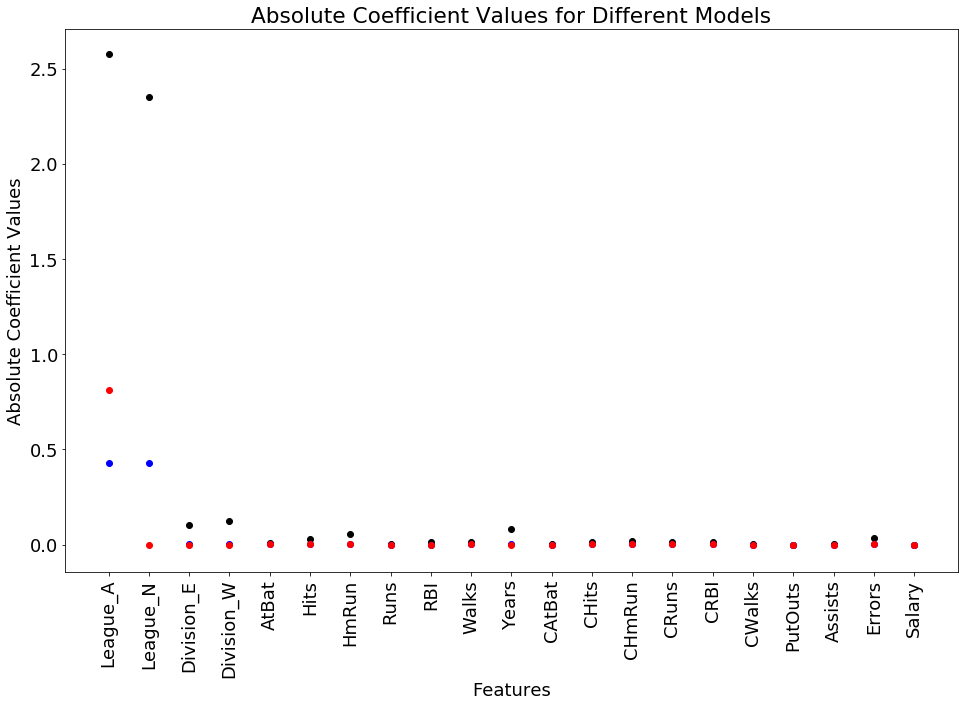

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy as np

plt.figure(figsize = (16,10)) 

plt.scatter(X.columns, np.abs(log_regressor.coef_), color='black', label = "logistic regression")
plt.scatter(X.columns, np.abs(ridge_regressor.coef_), color='blue', label = "ridge regression")
plt.scatter(X.columns, np.abs(lasso_regressor.coef_), color='red', label = "lasso regression")
#plt.plot(range(1, len(accuracy)+1), accuracy, linewidth=0.2, color = 'black')

plt.title('Absolute Coefficient Values for Different Models')
plt.xlabel('Features')
#plt.xticks(range(1, len(k_vals)+1), k_vals)
plt.ylabel('Absolute Coefficient Values')
plt.xticks(rotation='vertical')
plt.show()